In [1]:
pip install yfinance pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 13.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.6 MB/s eta 0:00:00:00:01
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317853 sha256=5ae904c3b0cfa6826cf101578b1bed00e936b7246ad8b484f607dfd183f8ffe3
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, GRU, Bidirectional, Dense
from keras.optimizers import Adam
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [91]:
ticker = "CL=F"
start_date = "2010-01-01"
end_date = "2024-12-18"

crude_oil_data = yf.download(ticker, start=start_date, end=end_date)

crude_oil_data.to_csv("crude_oil_data.csv")

crude_oil_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CL=F,CL=F,CL=F,CL=F,CL=F,CL=F
Date,,,,,,
2010-01-04,81.510002,81.510002,81.680000,79.629997,79.629997,263542
2010-01-05,81.769997,81.769997,82.000000,80.949997,81.629997,258887
2010-01-06,83.180000,83.180000,83.519997,80.849998,81.430000,370059
2010-01-07,82.660004,82.660004,83.360001,82.260002,83.199997,246632
2010-01-08,82.750000,82.750000,83.470001,81.800003,82.650002,310377


In [52]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

crude_oil_data = crude_oil_data.reindex(all_dates)

crude_oil_data.index.name = "Date"
crude_oil_data.reset_index(inplace=True)
crude_oil_data.to_csv("crude_oil_data_with_missing_dates.csv", index=False)
cols_to_modify = [('Adj Close', 'CL=F'), ('Close', 'CL=F'), ('High', 'CL=F'), ('Low', 'CL=F'), ('Open', 'CL=F'), ('Volume', 'CL=F')]

crude_oil_data.loc[crude_oil_data[('Adj Close', 'CL=F')] < 0, cols_to_modify] = np.nan


crude_oil_data.head()

Price        Date  Adj Close      Close   High        Low       Open    Volume
Ticker                  CL=F       CL=F   CL=F       CL=F       CL=F      CL=F
0      2010-01-01        NaN        NaN    NaN        NaN        NaN       NaN
1      2010-01-02        NaN        NaN    NaN        NaN        NaN       NaN
2      2010-01-03        NaN        NaN    NaN        NaN        NaN       NaN
3      2010-01-04  81.510002  81.510002  81.68  79.629997  79.629997  263542.0
4      2010-01-05  81.769997  81.769997  82.00  80.949997  81.629997  258887.0


In [53]:
crude_oil_data.isnull().sum()

Price      Ticker
Date                    0
Adj Close  CL=F      1704
Close      CL=F      1704
High       CL=F      1704
Low        CL=F      1704
Open       CL=F      1704
Volume     CL=F      1704
dtype: int64

In [48]:
crude_oil_data

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,CL=F,CL=F,CL=F,CL=F,CL=F,CL=F
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-04,81.510002,81.510002,81.680000,79.629997,79.629997,263542.0
4,2010-01-05,81.769997,81.769997,82.000000,80.949997,81.629997,258887.0
...,...,...,...,...,...,...,...
5461,2024-12-14,NaN,NaN,NaN,NaN,NaN,NaN
5462,2024-12-15,NaN,NaN,NaN,NaN,NaN,NaN
5463,2024-12-16,70.709999,70.709999,71.440002,70.370003,71.440002,204296.0


In [54]:
valid_rows = crude_oil_data.dropna().index

num_rows_to_nullify = int(0.1 * len(valid_rows))
rows_to_nullify = np.random.choice(valid_rows, size=num_rows_to_nullify, replace=False)

crude_oil_data.loc[rows_to_nullify, :] = np.nan

In [55]:
crude_oil_data.isnull().sum()

Price      Ticker
Date                  376
Adj Close  CL=F      2080
Close      CL=F      2080
High       CL=F      2080
Low        CL=F      2080
Open       CL=F      2080
Volume     CL=F      2080
dtype: int64

In [56]:
crude_oil_interpolated = crude_oil_data.interpolate(method='linear')
crude_oil_interpolated.bfill(inplace=True)

In [57]:
crude_oil_interpolated

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,CL=F,CL=F,CL=F,CL=F,CL=F,CL=F
0,2010-01-01,81.510002,81.510002,81.680000,79.629997,79.629997,263542.0
1,2010-01-02,81.510002,81.510002,81.680000,79.629997,79.629997,263542.0
2,2010-01-03,81.510002,81.510002,81.680000,79.629997,79.629997,263542.0
3,2010-01-04,81.510002,81.510002,81.680000,79.629997,79.629997,263542.0
4,2010-01-05,81.769997,81.769997,82.000000,80.949997,81.629997,258887.0
...,...,...,...,...,...,...,...
5461,2024-12-14,71.096667,71.096667,71.426666,70.036669,70.519999,221718.0
5462,2024-12-15,70.903333,70.903333,71.433334,70.203336,70.980001,213007.0
5463,2024-12-16,70.709999,70.709999,71.440002,70.370003,71.440002,204296.0


<Figure size 1000x600 with 0 Axes>

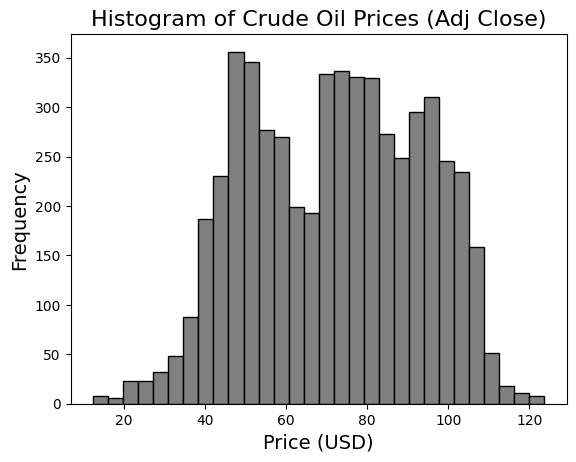

In [92]:
plt.figure(figsize=(10, 6))

crude_oil_interpolated['Adj Close'].hist(bins=30, color='gray', edgecolor='black')


plt.title('Histogram of Crude Oil Prices (Adj Close)', fontsize=16)
plt.xlabel('Price (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(False)
plt.show()

In [59]:
split_index = int(len(crude_oil_interpolated) * 0.7)

train_data = crude_oil_interpolated.iloc[:split_index].copy()

test_data = crude_oil_interpolated.iloc[split_index:].copy()
scaler = MinMaxScaler()

train_data.loc[:, 'Adj Close'] = scaler.fit_transform(train_data[['Adj Close']])
test_data.loc[:, 'Adj Close'] = scaler.transform(test_data[['Adj Close']])

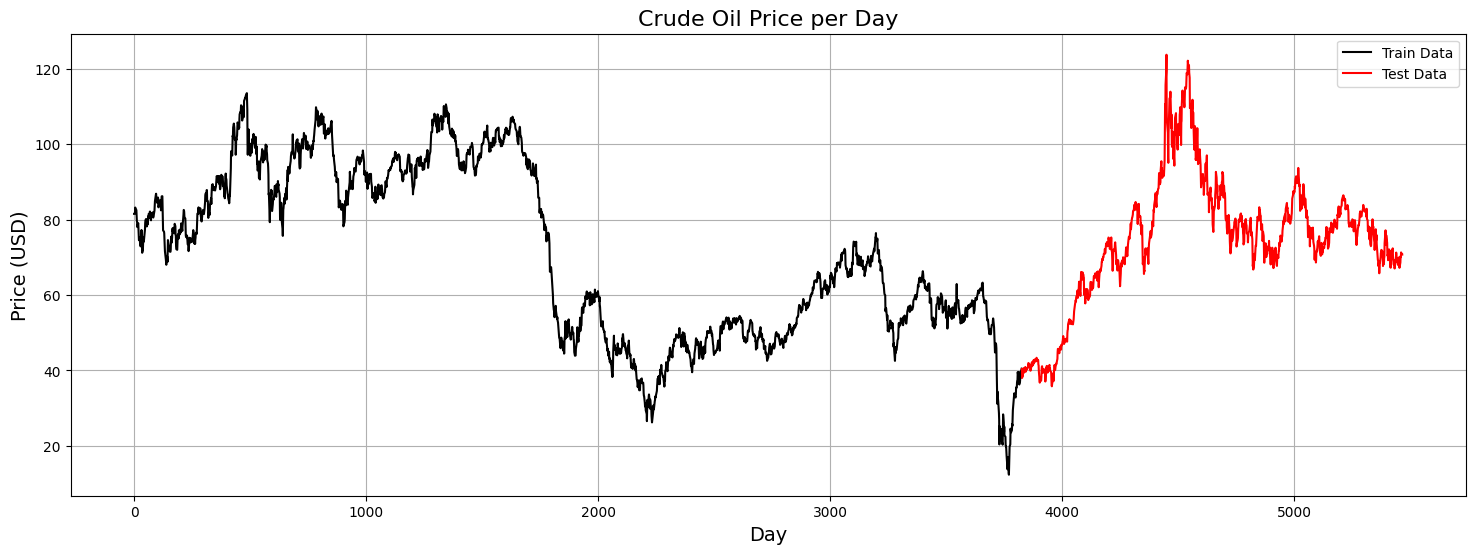

In [93]:
split_index = int(len(crude_oil_interpolated) * 0.7)
train_data2 = crude_oil_interpolated.iloc[:split_index].copy()

test_data2 = crude_oil_interpolated.iloc[split_index:].copy()

plt.figure(figsize=(18, 6))
plt.plot(train_data2.index, train_data2['Adj Close'], label='Train Data', color='black')

plt.plot(test_data2.index, test_data2['Adj Close'], label='Test Data', color='red')

plt.title('Crude Oil Price per Day', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

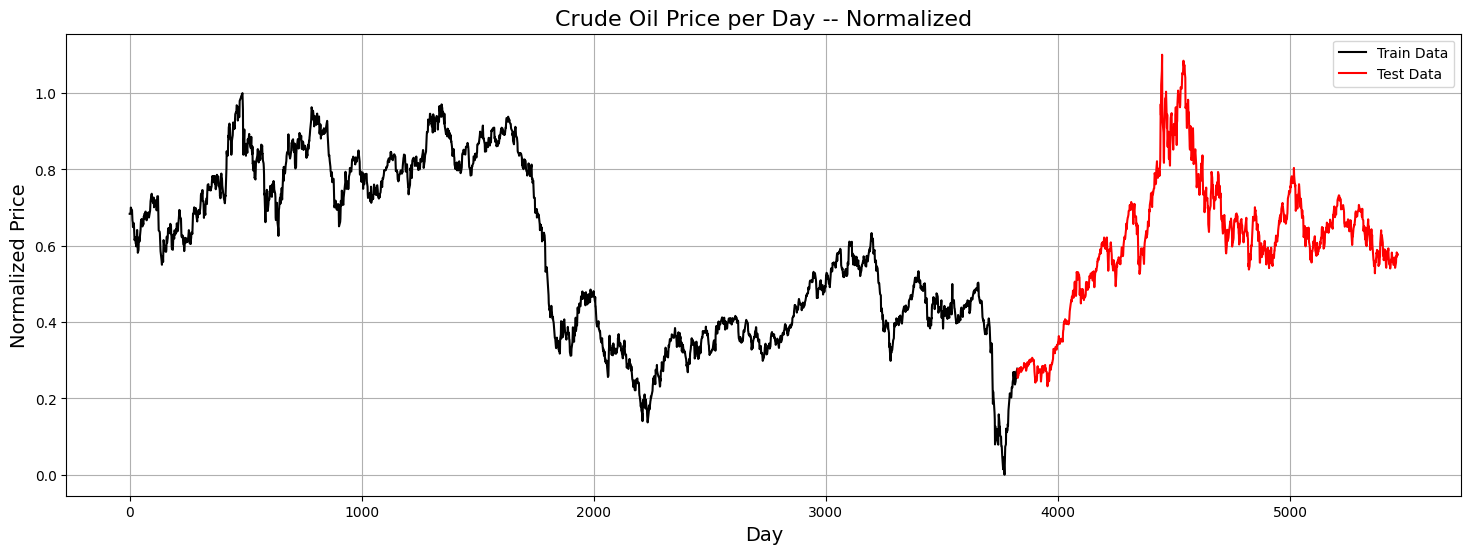

In [94]:
plt.figure(figsize=(18, 6))
plt.plot(train_data.index, train_data['Adj Close'], label='Train Data', color='black')

plt.plot(test_data.index, test_data['Adj Close'], label='Test Data', color='red')

plt.title('Crude Oil Price per Day -- Normalized', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Normalized Price', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

In [63]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 2
train_sequences, train_labels = create_sequences(train_data['Adj Close'].values, sequence_length)
test_sequences, test_labels = create_sequences(test_data['Adj Close'].values, sequence_length)

train_sequences = train_sequences.reshape(train_sequences.shape[0], train_sequences.shape[1], 1)
test_sequences = test_sequences.reshape(test_sequences.shape[0], test_sequences.shape[1], 1)

## LSTM

In [64]:
model = Sequential([
    LSTM(512, input_shape=(train_sequences.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(train_sequences, train_labels, epochs=50, batch_size=100, validation_data=(test_sequences, test_labels), verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1477 - val_loss: 0.0048
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0036 - val_loss: 6.5531e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.9818e-04 - val_loss: 3.4922e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.8131e-04 - val_loss: 3.5596e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.8420e-04 - val_loss: 3.5883e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.8374e-04 - val_loss: 3.5912e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.6634e-04 - val_loss: 3.5202e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.8035e-04 - val_loss: 3.5089e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.8336e-04 - val_loss: 3.5158e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.7999e-04 - val_loss: 3.5011e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.8649e-04 - val_loss

In [65]:
train_predictions = model.predict(train_sequences)
test_predictions = model.predict(test_sequences)

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [66]:
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    r2 = r2_score(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mae, rmse, r2, mape

train_mae, train_rmse, train_r2, train_mape = calculate_metrics(scaler.inverse_transform(train_labels), scaler.inverse_transform(train_predictions))
test_mae, test_rmse, test_r2, test_mape = calculate_metrics(scaler.inverse_transform(test_labels), scaler.inverse_transform(test_predictions))

print("Training Metrics:")
print(f"MAE: {train_mae:}, RMSE: {train_rmse:}, R-Squared: {train_r2:}, MAPE: {train_mape:}%")

print("Testing Metrics:")
print(f"MAE: {test_mae:}, RMSE: {test_rmse:}, R-Squared: {test_r2:}, MAPE: {test_mape:}%")

Training Metrics:
MAE: 1.0836006584443487, RMSE: 1.4598747528999694, R-Squared: 0.9959132957094331, MAPE: 1.7632018012975335%
Testing Metrics:
MAE: 1.3234234898760895, RMSE: 1.9269472783961048, R-Squared: 0.9871828699089974, MAPE: 1.7550499256100167%


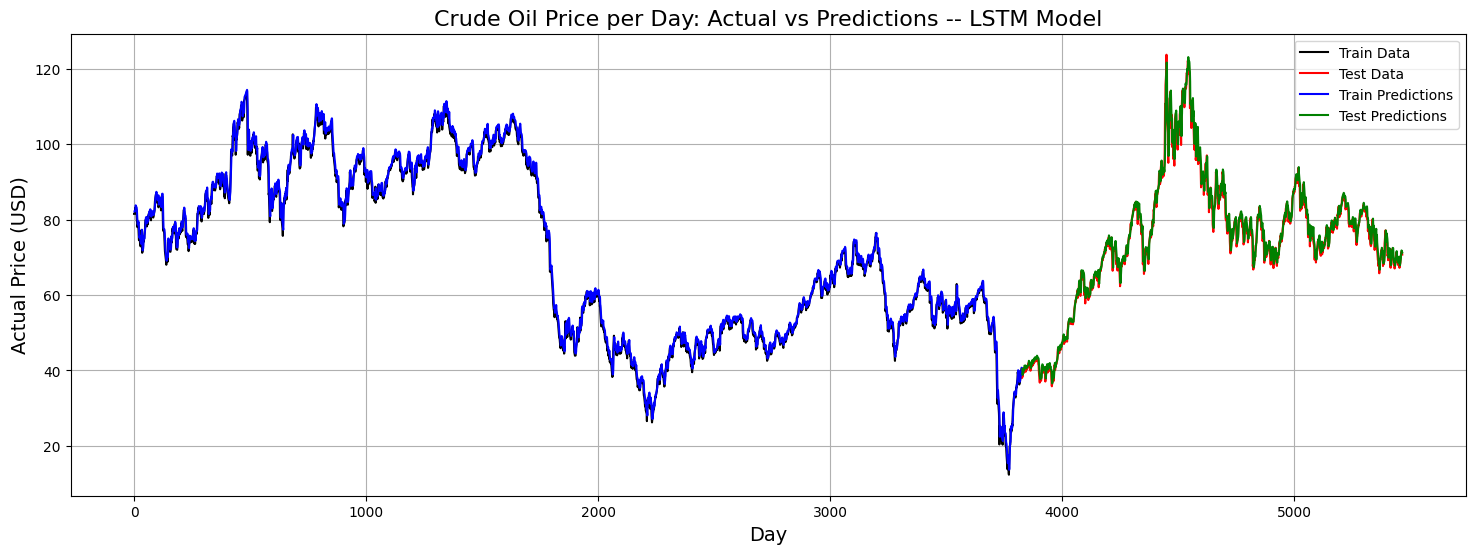

In [95]:
train_index = train_data.index[sequence_length:]
test_index = test_data.index[sequence_length:]

plt.figure(figsize=(18, 6))
plt.plot(train_data.index, scaler.inverse_transform(train_data['Adj Close']), label='Train Data', color='black')
plt.plot(test_data.index, scaler.inverse_transform(test_data['Adj Close']), label='Test Data', color='red')

plt.plot(train_index, scaler.inverse_transform(train_predictions), label='Train Predictions', color='blue')
plt.plot(test_index, scaler.inverse_transform(test_predictions), label='Test Predictions', color='green')

plt.title('Crude Oil Price per Day: Actual vs Predictions -- LSTM Model', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Actual Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

### GRU

In [74]:
gru_model = Sequential([
    GRU(512, input_shape=(train_sequences.shape[1], 1)),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

gru_history = gru_model.fit(train_sequences, train_labels, 
                            epochs=50, batch_size=100, 
                            validation_data=(test_sequences, test_labels), 
                            verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1164 - val_loss: 0.0035
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020 - val_loss: 3.5979e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.8086e-04 - val_loss: 3.3632e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6072e-04 - val_loss: 3.3434e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6076e-04 - val_loss: 3.3571e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.6102e-04 - val_loss: 3.3232e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.7833e-04 - val_loss: 3.3129e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.6328e-04 - val_loss: 3.3135e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.6159e-04 - val_loss: 3.3164e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.6488e-04 - val_loss: 3.3274e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.6280e-04 - val_loss

In [75]:
gru_train_predictions = gru_model.predict(train_sequences)
gru_test_predictions = gru_model.predict(test_sequences)

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [76]:
train_mae, train_rmse, train_r2, train_mape = calculate_metrics(scaler.inverse_transform(train_labels), scaler.inverse_transform(gru_train_predictions))
test_mae, test_rmse, test_r2, test_mape = calculate_metrics(scaler.inverse_transform(test_labels), scaler.inverse_transform(gru_test_predictions))

print("Training Metrics:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, R-Squared: {train_r2}, MAPE: {train_mape}%")

print("Testing Metrics:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, R-Squared: {test_r2}, MAPE: {test_mape}%")

Training Metrics:
MAE: 0.8786767602786285, RMSE: 1.2483718650958844, R-Squared: 0.9970116603135265, MAPE: 1.4363885230848517%
Testing Metrics:
MAE: 1.2227341775735014, RMSE: 1.763617857620762, R-Squared: 0.9892635649115601, MAPE: 1.607297852633034%


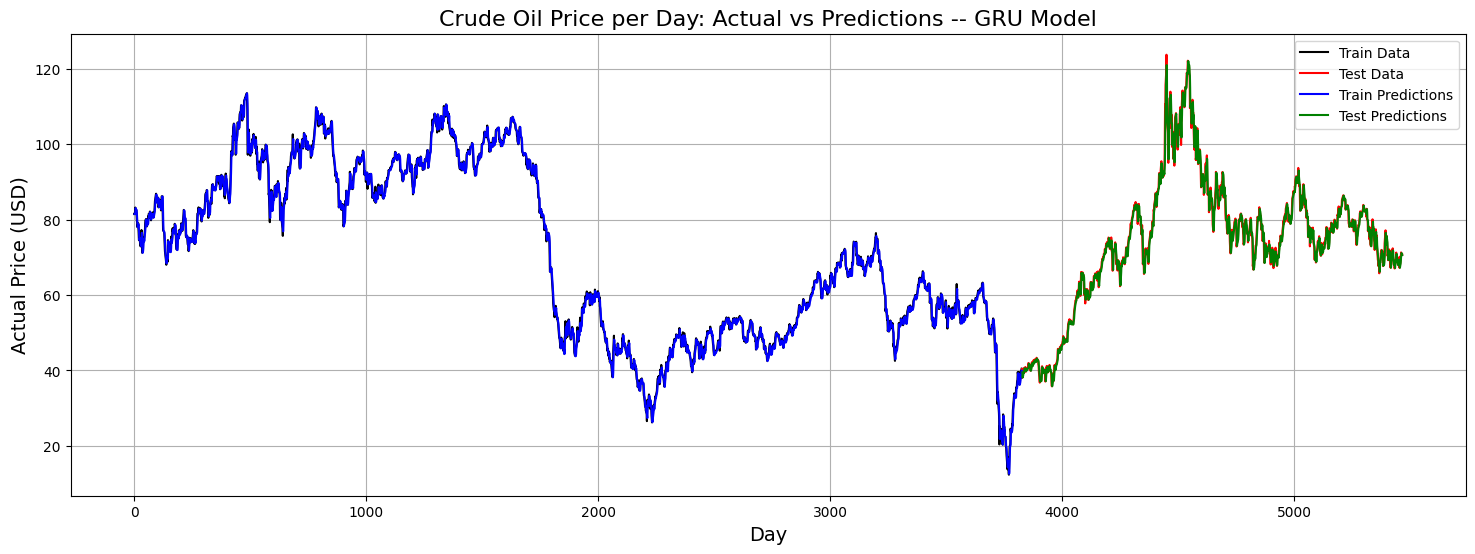

In [96]:
train_index = train_data.index[sequence_length:]
test_index = test_data.index[sequence_length:]

plt.figure(figsize=(18, 6))
plt.plot(train_data.index, scaler.inverse_transform(train_data['Adj Close']), label='Train Data', color='black')
plt.plot(test_data.index, scaler.inverse_transform(test_data['Adj Close']), label='Test Data', color='red')

plt.plot(train_index, scaler.inverse_transform(gru_train_predictions), label='Train Predictions', color='blue')
plt.plot(test_index, scaler.inverse_transform(gru_test_predictions), label='Test Predictions', color='green')

plt.title('Crude Oil Price per Day: Actual vs Predictions -- GRU Model', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Actual Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

### Bi-LSTM

In [78]:
bi_lstm_model = Sequential([
    Bidirectional(LSTM(1024), input_shape=(train_sequences.shape[1], 1)),
    Dense(1)
])
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

bi_lstm_history = bi_lstm_model.fit(train_sequences, train_labels, 
                                    epochs=50, batch_size=100, 
                                    validation_data=(test_sequences, test_labels), 
                                    verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.0944 - val_loss: 9.0260e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 9.8221e-04 - val_loss: 2.9914e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 1.5315e-04 - val_loss: 2.5496e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - loss: 1.2162e-04 - val_loss: 2.5491e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 1.2514e-04 - val_loss: 2.5518e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - loss: 1.2642e-04 - val_loss: 2.5371e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - loss: 1.2890e-04 - val_loss: 2.5362e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 1.2747e-04 - val_loss: 2.5919e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 1.2416e-04 - val_loss: 2.5601e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - loss: 1.3733e-04 - val_loss: 2.5276e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - loss

In [79]:
bi_lstm_train_predictions = bi_lstm_model.predict(train_sequences)
bi_lstm_test_predictions = bi_lstm_model.predict(test_sequences)

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [80]:
train_mae, train_rmse, train_r2, train_mape = calculate_metrics(scaler.inverse_transform(train_labels), scaler.inverse_transform(bi_lstm_train_predictions))
test_mae, test_rmse, test_r2, test_mape = calculate_metrics(scaler.inverse_transform(test_labels), scaler.inverse_transform(bi_lstm_test_predictions))

print("Training Metrics:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, R-Squared: {train_r2}, MAPE: {train_mape}%")

print("Testing Metrics:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, R-Squared: {test_r2}, MAPE: {test_mape}%")

Training Metrics:
MAE: 0.803297230131624, RMSE: 1.1351047147903772, R-Squared: 0.9975293349426206, MAPE: 1.3157182122147182%
Testing Metrics:
MAE: 1.0349725664268439, RMSE: 1.5464709695697518, R-Squared: 0.9917446655793164, MAPE: 1.3631893340507204%


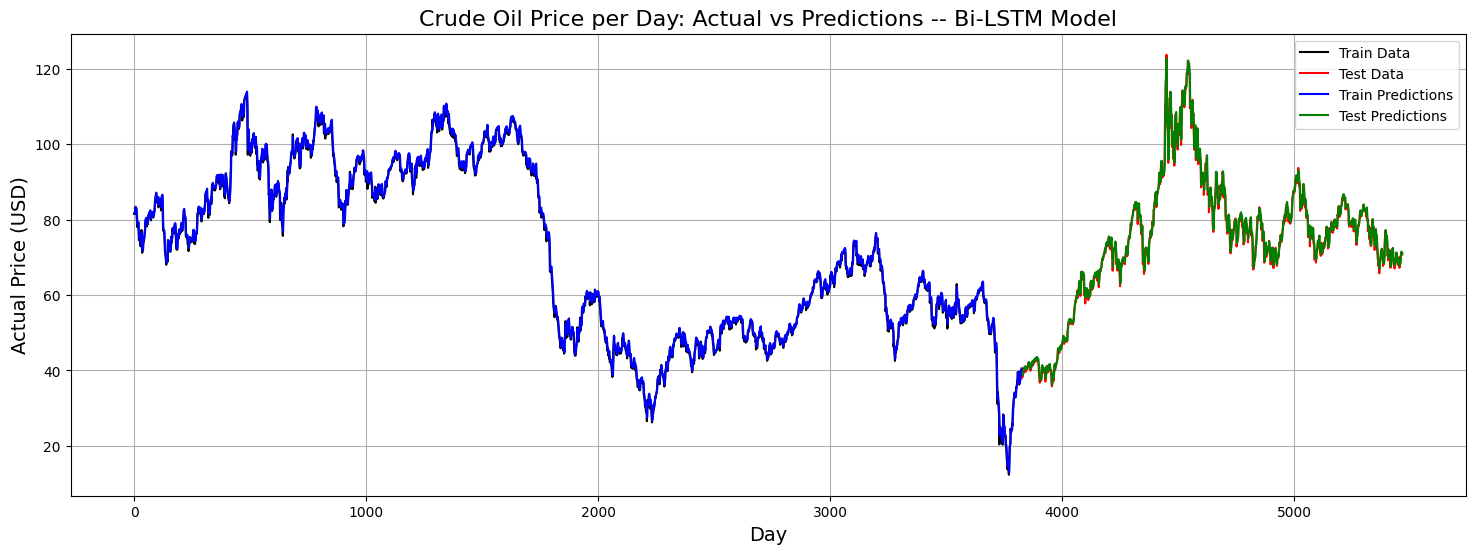

In [98]:
train_index = train_data.index[sequence_length:]
test_index = test_data.index[sequence_length:]

plt.figure(figsize=(18, 6))
plt.plot(train_data.index, scaler.inverse_transform(train_data['Adj Close']), label='Train Data', color='black')
plt.plot(test_data.index, scaler.inverse_transform(test_data['Adj Close']), label='Test Data', color='red')

plt.plot(train_index, scaler.inverse_transform(bi_lstm_train_predictions), label='Train Predictions', color='blue')
plt.plot(test_index, scaler.inverse_transform(bi_lstm_test_predictions), label='Test Predictions', color='green')

plt.title('Crude Oil Price per Day: Actual vs Predictions -- Bi-LSTM Model', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Actual Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

### ARIMA

In [83]:
arima_train_data = scaler.inverse_transform(train_data['Adj Close'].values.reshape(-1, 1)).flatten()
arima_test_data = scaler.inverse_transform(test_data['Adj Close'].values.reshape(-1, 1)).flatten()

auto_arima_model = auto_arima(
    arima_train_data,
    start_p=1, start_q=1,
    max_p=5, max_q=5,  # Range for p and q
    d=None,            # Automatically determine 'd'
    seasonal=False,    
    trace=True,       
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True       
)

print(f"Best ARIMA parameters: {auto_arima_model.order}")

auto_arima_model_fit = auto_arima_model.fit(arima_train_data)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10759.642, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10791.942, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10761.854, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10764.258, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10790.391, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10760.723, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10760.642, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10758.751, Time=0.77 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10760.609, Time=1.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10762.724, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10757.104, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10762.642, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=10758.990, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=10758.957, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0

In [84]:
rolling_predictions = []
history = list(arima_train_data)

for actual in arima_test_data:
    model = ARIMA(history, order=auto_arima_model.order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=1)[0]
    rolling_predictions.append(forecast)

    history.append(actual)

Rolling Auto-ARIMA Test Metrics:
MAE: 0.8758083444275948, RMSE: 1.3780820925263362, R-Squared: 0.9934711777838529, MAPE: 1.153950790317823%


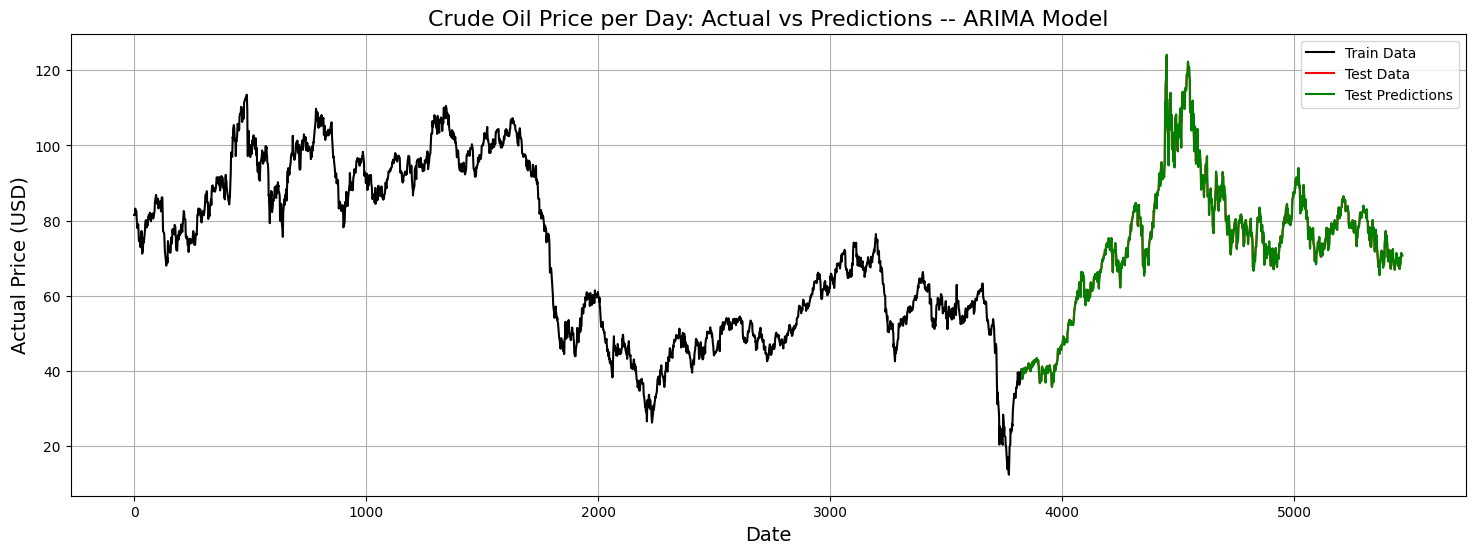

In [89]:
rolling_metrics = calculate_metrics(arima_test_data, rolling_predictions)
print("Rolling Auto-ARIMA Test Metrics:")
print(f"MAE: {rolling_metrics[0]}, RMSE: {rolling_metrics[1]}, R-Squared: {rolling_metrics[2]}, MAPE: {rolling_metrics[3]}%")

plt.figure(figsize=(18, 6))

plt.plot(train_data.index, arima_train_data, label='Train Data', color='black')
plt.plot(test_data.index, arima_test_data, label='Test Data', color='red')

plt.plot(test_data.index, rolling_predictions, label='Test Predictions', color='green')

plt.title('Crude Oil Price per Day: Actual vs Predictions -- ARIMA Model', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Actual Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()